Copyright &copy; 2012 Ondrej Martinsky, All rights reserved

[www.quantandfinancial.com](http://www.quantandfinancial.com)
# Treasury Yield Curve Bootstrapping

#### Mathematical symbols used in this notebook

| Symbol | Comment
| -- | --
| tr | Time to maturity
| t | Time to maturity (interpolated)
| yr | Yield to maturity
| y | Yield to maturity (interpolated)
| s | Bootstrapped spot rate

### Load data

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 6)

import scipy.interpolate
from pandas import *

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
bonds = read_csv('gilts_2012_09_19.csv', index_col=None, parse_dates=['maturity'])

#### Calculate "time to maturity" column

In [3]:
current_date = datetime(2012, 9, 19)
ttm = [(maturity - current_date).days / 360 for maturity in bonds['maturity']]
bonds['time to maturity'] = ttm
bonds

,epic,description,coupon,maturity,bid,ask,change,income yield,gross redemption yield,time to maturity
0,TR13,Uk Gilt Treasury Stk,4.50,2013-03-07,101.92,102.07,-0.01,4.41,0.22,0.469444
1,T813,Uk Gilt Treasury Stk,8.00,2013-09-27,107.86,107.98,-0.03,7.41,0.23,1.036111
2,TR14,Uk Gilt Treasury Stk,2.25,2014-03-07,102.90,103.05,0.01,2.18,0.22,1.483333
3,T514,Uk Gilt Treasury Stk,5.00,2014-09-07,109.28,109.43,0.02,4.57,0.23,1.994444
4,TR15,Uk Gilt Treasury Stk,2.75,2015-01-22,105.57,105.68,0.05,2.60,0.33,2.375000
5,T4T,Uk Gilt Treasury Stk,4.75,2015-09-07,112.92,113.04,0.04,4.20,0.35,3.008333
6,TY8,Uk Gilt Treasury Stk,8.00,2015-12-07,124.39,124.55,0.04,6.43,0.34,3.261111
7,TS16,Uk Gilt Treasury Stk,2.00,2016-01-22,104.92,105.04,0.07,1.91,0.49,3.388889
8,T16,Uk Gilt Treasury Stk,4.00,2016-09-07,113.44,113.55,0.08,3.52,0.56,4.025000
9,TR17,Uk Gilt Treasury Stk,8.75,2017-08-25,138.48,138.66,0.14,6.31,0.77,5.002778


### Import Time value of money calculator

In [4]:
import tvm

### Calculate yield curve
Calculated YTMs doesn't necessarily correspond to those quoted in data file (source: Bondscape.net), due to accrued interest and a fact that coupon payment are bound to some specific calendar date, not necessarily, one semiannually.

_Please note that source data from BondScape.net already contains Gross Redemption Yield, which is not used for the sake of this example (but corresponds to the yield calculated using time-value-of-money calculator_

In [5]:
tr, yr = [], []
current_date = datetime(2012, 9, 19)
for i, bond in bonds.iterrows():
    ttm = bond['time to maturity']
    price = (bond['bid'] + bond['ask']) / 2
    freq = 2 # semiannually
    ytm = tvm.TVM(n=ttm * freq, pv=-price, pmt=bond['coupon'] / freq, fv=100).calc_r() * freq
    tr.append(ttm)
    yr.append(ytm)

### Interpolation
Interpolate on-the-run yield curve to get yields on node dates (1Y, 2Y, ...), so they can be used in bootstrapping

In [6]:
t = list(i for i in range(1, 41))
y = []
interp = scipy.interpolate.interp1d(tr, yr, bounds_error=False, fill_value=scipy.nan)
for i in t:
    value = float(interp(i))
    if not scipy.isnan(value):
        y.append(value)

### Bootstrapping
To bootstrap the yield curve, we will be building upon a fact that all bonds priced at par have coupon rate equal to the yield-to-maturity, as denoted in the following equation:

$$ \frac{C}{\left ( 1+r \right )^1} + \frac{C}{\left ( 1+r \right )^2}+...+\frac{1+C}{\left ( 1+r \right )^n} = 100 $$

In [7]:
s = []  # output array for spot rates
for i in range(0, len(t)):  # calculate i-th spot rate
    sum = 0
    for j in range(0, i):  # by iterating through 0..i
        sum += y[i] / (1 + s[j]) ** t[j]
    value = ((1 + y[i]) / (1 - sum)) ** (1 / t[i]) - 1
    s.append(value)

### Display

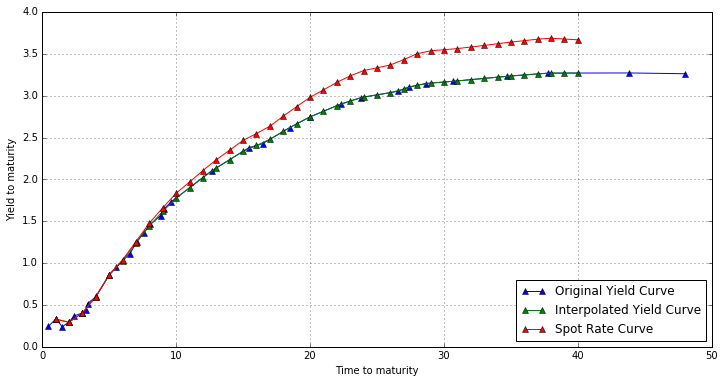

In [8]:
xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plot(tr, array(yr)*100, marker='^', label='Original Yield Curve')
plot(t, array(y)*100, marker='^', label='Interpolated Yield Curve')
plot(t, array(s)*100, marker='^', label='Spot Rate Curve')
legend(loc=4), show();